<a href="https://colab.research.google.com/github/AlsoSprachZarathushtra/Quick-Draw-Recognition/blob/master/StrokeColor_DenseNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Connect Google Drive

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Import

In [0]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os

from tensorflow import keras
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import ReLU
from tensorflow.keras.layers import Softmax
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.metrics import sparse_top_k_categorical_accuracy
from tensorflow.keras.callbacks import CSVLogger
from ast import literal_eval

# Parameters  and  Work-Space Paths

In [0]:
# parameters
BATCH_SIZE = 128
EPOCHS = 40
STEPS_PER_EPOCH = 1000
VALIDATION_STEPS = 100
EVALUATE_STEPS = 1700
IMAGE_SIZE = 128
LINE_SIZE = 4
n_class = 340

# load path
TRAIN_DATA_PATH = 'gdrive/My Drive/QW/Data/Data_10000/All_classes_10000.csv'
VALID_DATA_PATH = 'gdrive/My Drive/QW/Data/My_test_data/My_test_data.csv'
LABEL_DICT_PATH = 'gdrive/My Drive/QW/Data/labels_dict.npy'

# save path
CKPT_PATH = 'gdrive/My Drive/QW/Notebook/Quick Draw/Thesis_pre_research/Stroke_DenseNet/best_model_densenet.ckpt'
LOSS_PLOT_PATH = 'gdrive/My Drive/QW/Notebook/Quick Draw/Thesis_pre_research/Stroke_DenseNet/loss_plot_densenet.png'
ACC_PLOT_PATH = 'gdrive/My Drive/QW/Notebook/Quick Draw/Thesis_pre_research/Stroke_DenseNet/acc_plot_densenet.png'
LOG_PATH = 'gdrive/My Drive/QW/Notebook/Quick Draw/Thesis_pre_research/Stroke_DenseNet/Log_densenet.log'

print('finish!')

finish!


# Generator

In [0]:
def generate_data(data, batch_size, choose_recognized):
    data = data.sample(frac = 1)
    while 1:
        
#         get columns' values named 'drawing', 'word' and 'recognized'
        drawings = data["drawing"].values
        drawing_recognized = data["recognized"].values
        drawing_class = data["word"].values
      
#         initialization
        cnt = 0
        data_X =[]
        data_Y =[]
        
#         generate batch
        for i in range(len(drawings)):
            if choose_recognized:
                if drawing_recognized[i] == 'False':    #Choose according to recognized value
                    continue
            draw = drawings[i]
            label = drawing_class[i]
            stroke_vec = literal_eval(draw)
            img = np.zeros([256, 256])
            x = []
            for j in range(len(stroke_vec)): 
                line = np.array(stroke_vec[j]).T
                color = 255-(13*min(j,10))
                cv2.polylines(img, [line], False, color, LINE_SIZE)
            img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE), interpolation = cv2.INTER_NEAREST)
            img = img[:,:, np.newaxis]
            x = img
            y = labels2nums_dict[label]
            data_X.append(x)
            data_Y.append(y)
            cnt += 1
            if cnt==batch_size:        #generate a batch when cnt reaches batch_size 
                cnt = 0
                yield (np.array(data_X), np.array(data_Y))
                data_X = []
                data_Y = []

print('finish!')

finish!


# Callbacks

In [0]:
# define a class named LossHitory 
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch':[], 'epoch':[]}
        self.accuracy = {'batch':[], 'epoch':[]}
        self.val_loss = {'batch':[], 'epoch':[]}
        self.val_acc = {'batch':[], 'epoch':[]}

    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('acc'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_acc['batch'].append(logs.get('val_acc'))

    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.accuracy['epoch'].append(logs.get('acc'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_acc['epoch'].append(logs.get('val_acc'))

    def loss_plot(self, loss_type, loss_fig_save_path, acc_fig_save_path):
        iters = range(len(self.losses[loss_type]))
        plt.figure('acc')
        plt.plot(iters, self.accuracy[loss_type], 'r', label='train acc')
        plt.plot(iters, self.val_acc[loss_type], 'b', label='val acc')
        plt.grid(True)
        plt.xlabel(loss_type)
        plt.ylabel('acc')
        plt.legend(loc="upper right")
        plt.savefig(acc_fig_save_path)
        plt.show()
        
        
        plt.figure('loss')
        plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
        plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss')
        plt.grid(True)
        plt.xlabel(loss_type)
        plt.ylabel('loss')
        plt.legend(loc="upper right")
        plt.savefig(loss_fig_save_path)
        plt.show()
        
# create a object from LossHistory class
History = LossHistory()

print("finish!")

finish!


In [0]:

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    CKPT_PATH, 
    verbose = 1, 
    monitor='val_acc', 
    mode = 'max', 
    save_best_only=True)

print("finish!")

finish!


In [0]:
ReduceLR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=3,
                      min_delta=0.005, mode='max', cooldown=3, verbose=1)

In [0]:
csv_logger = CSVLogger(LOG_PATH, separator=',', append=True)

# Load Data

In [0]:
# load train data and valid data
#  labels_dict and data path

# labels convert into nums
labels_dict = np.load(LABEL_DICT_PATH)
labels2nums_dict = {v: k for k, v in enumerate(labels_dict)}

# read csv 
train_data = pd.read_csv(TRAIN_DATA_PATH)
valid_data = pd.read_csv(VALID_DATA_PATH)

print('finish!')

finish!


# Model

In [0]:

MODEL = tf.keras.applications.DenseNet121(
        input_shape=(IMAGE_SIZE,IMAGE_SIZE,1),
        include_top=True,
        weights=None,
        classes=n_class
        )

MODEL.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 134, 134, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 64, 64, 64)   3136        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalizationV1) (None, 64, 64, 64)   256         conv1/conv[0][0]                 
_____________________________________

# Complie

In [0]:
model = MODEL

TPU_model = tf.contrib.tpu.keras_to_tpu_model(
    model,
    strategy=tf.contrib.tpu.TPUDistributionStrategy(
            tf.contrib.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
        )
    )


TPU_model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,
                  optimizer=tf.train.AdamOptimizer(learning_rate=1e-5),
                  metrics=['accuracy'])
TPU_model.load_weights(CKPT_PATH)
print('finish')



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

INFO:tensorflow:Querying Tensorflow master (grpc://10.10.98.18:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 11422646713076668804)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 10110685780123374831)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 162110997482080377)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1,

# Train

start training
Epoch 21/40
INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(16,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(16, 128, 128, 1), dtype=tf.float32, name='input_1_10'), TensorSpec(shape=(16, 1), dtype=tf.int32, name='fc1000_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 102.12913990020752 secs
INFO:tensorflow:Setting weights on TPU model.
 999/1000 [============================>.] - ETA: 0s - loss: 1.1093 - acc: 0.7221INFO:tensorflow:New input shapes; (re-)compiling: mode=eval (# of cores 8), [TensorSpec(shape=(16,), dtype=tf.int32, name='core_id_10'), TensorSpec(shape=(16, 128, 128, 1), dtype=tf.float32, name='input_1_10'), TensorSpec(shape=(16, 1), dtype=tf.int32, name='fc1000_

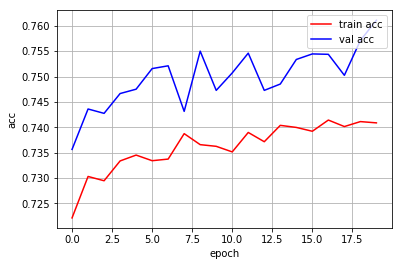

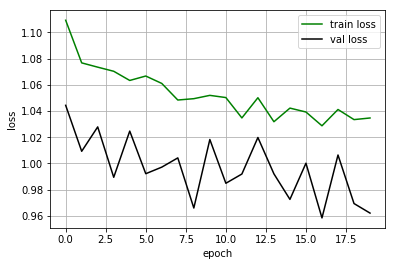

finish!


In [0]:
print('start training')
# callbacks = [History, cp_callback]

history = TPU_model.fit_generator(generate_data(train_data, BATCH_SIZE, True),
                              steps_per_epoch = STEPS_PER_EPOCH,
                              epochs = EPOCHS,
                              validation_data = generate_data(valid_data, BATCH_SIZE, False) ,
                              validation_steps = VALIDATION_STEPS,
                              verbose = 1,
                              initial_epoch = 20,
                              callbacks = [History,cp_callback,csv_logger]
                             )
print("finish training")

History.loss_plot('epoch', LOSS_PLOT_PATH, ACC_PLOT_PATH)

print('finish!')

# Evaluate

In [0]:
def top_3_accuracy(X, Y):
    return sparse_top_k_categorical_accuracy(X, Y, 3)
  
def top_5_accuracy(X, Y):
    return sparse_top_k_categorical_accuracy(X, Y, 5)
  
model_E = MODEL
model_E.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,
              optimizer=tf.train.AdamOptimizer(),
              metrics=['accuracy',top_3_accuracy, top_5_accuracy])

model_weights_path = CKPT_PATH
model_E.load_weights(model_weights_path)
print('finish')

finish


In [0]:
result = model_E.evaluate_generator(
    generate_data(valid_data, BATCH_SIZE, False),
    steps = EVALUATE_STEPS,
    verbose = 1
)

print('loss:', result[0])
print('top1 accuracy:', result[1])
print('top3 accuracy:', result[2])
print('top3 accuracy:', result[3])

850/850 [==============================] - 138s 162ms/step
loss: 0.8496719417501898
top1 accuracy: 0.7838941168083864
top3 accuracy: 0.9139941189569586
top3 accuracy: 0.9383294103426092
